In [2]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import cv2

import os

import glob as gb

import tensorflow as tf

from keras.applications import MobileNet

from keras.models import Sequential

from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

from keras.optimizers import Adam 

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator

from keras.applications.mobilenet import preprocess_input

from tensorflow.keras.regularizers import L2

from sklearn.metrics import classification_report, confusion_matrix



# directories

train_dir = 'pest/train/'

test_dir = 'pest/test/'



# Create image data generators for training, validation, and testing

training_data_generator = ImageDataGenerator(

  zca_epsilon=1e-06,

  rotation_range=20,

  width_shift_range=0.1,

  height_shift_range=0.1,

  shear_range=0.1,

  zoom_range=0.1,

  fill_mode="nearest",

  horizontal_flip=True,

  vertical_flip=True,

  preprocessing_function=preprocess_input,

  validation_split=0.1

)



validation_data_generator = ImageDataGenerator(

  rotation_range=20,

  width_shift_range=0.1,

  height_shift_range=0.1,

  shear_range=0.1,

  zoom_range=0.1,

  fill_mode="nearest",

  horizontal_flip=True,

  vertical_flip=True,

  preprocessing_function=preprocess_input,

  validation_split=0.1

)



testing_data_generator = ImageDataGenerator(

  preprocessing_function=preprocess_input

)



# Flow training, validation, and testing images in batches of 32 using the data generators

training_generator = training_data_generator.flow_from_directory(

  train_dir,

  target_size=(224, 224),

  batch_size=32,

  class_mode='categorical',

  subset='training'

)



validation_generator = validation_data_generator.flow_from_directory(

  train_dir,

  target_size=(224, 224),

  batch_size=32,

  class_mode='categorical',

  subset='validation'

)



testing_generator = testing_data_generator.flow_from_directory(

  test_dir,

  target_size=(224, 224),

  batch_size=32,

  class_mode='categorical',

  shuffle=False

)



# Load MobileNet 

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



# Freeze the base model

base_model.trainable = False





model = Sequential([

  base_model,

  GlobalAveragePooling2D(),

  Dense(128, activation='relu', kernel_regularizer=L2(l=0.001)),

  BatchNormalization(),

  Dropout(0.5),

  Dense(64, activation='relu', kernel_regularizer=L2(l=0.001)),

  BatchNormalization(),

  Dropout(0.5),

  Dense(11, activation='softmax')

])



# Compile the model with a lower learning rate

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])



# Train the model with adjusted hyperparameters

history = model.fit(

  training_generator,

  validation_data=validation_generator,

  epochs=20,

  callbacks=[

    EarlyStopping(patience=5, restore_best_weights=True),

    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)

  ],

  verbose=1

)



# Evaluate on the test set

loss, acc = model.evaluate(testing_generator)

print(f"Test Accuracy: {acc}")







Found 2916 images belonging to 11 classes.
Found 320 images belonging to 11 classes.
Found 690 images belonging to 11 classes.




Epoch 1/20



92/92 [==============================] - 65s 686ms/step - loss: 2.6064 - accuracy: 0.3241 - val_loss: 1.5787 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 2/20
92/92 [==============================] - 55s 592ms/step - loss: 1.7515 - accuracy: 0.5329 - val_loss: 1.4334 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 3/20
92/92 [==============================] - 57s 614ms/step - loss: 1.4661 - accuracy: 0.6135 - val_loss: 1.2708 - val_accuracy: 0.6906 - lr: 0.0010
Epoch 4/20
92/92 [==============================] - 56s 604ms/step - loss: 1.3109 - accuracy: 0.6728 - val_loss: 1.1434 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 5/20
92/92 [==============================] - 55s 599ms/step - loss: 1.1584 - accuracy: 0.7202 - val_loss: 1.0957 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 6/20
92/92 [==============================] - 55s 597ms/step - loss: 1.0608 - accuracy: 0.7671 - val_loss: 1.0908 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 7/20
92/92 [==============================] - 55s 600ms/step - loss: 

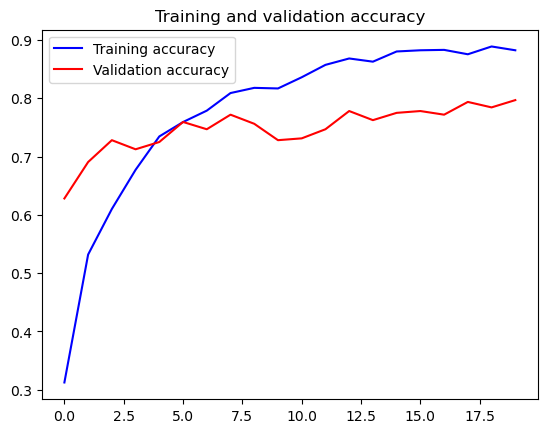

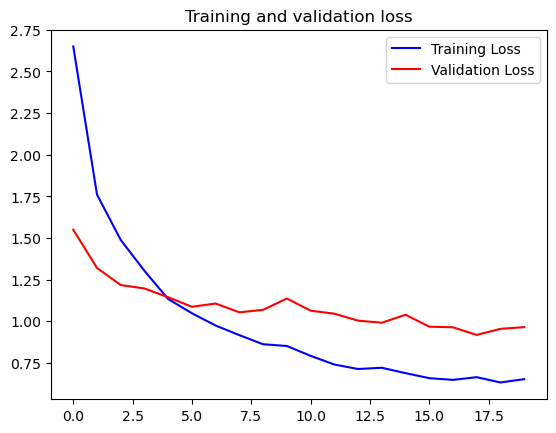

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

22/22 [==============================] - 7s 303ms/step
Confusion Matrix:
[[ 66   0   0   0   2   0   3   1   1   0   0]
 [  0  71   0   0   0   0   0   0   0   0   1]
 [  0   1  58   0   0   0   0   1   0   0   0]
 [  0   2   0  47   0   0   0   0   0   0   1]
 [  4   0   1   0  30   0   0   1   0   0   0]
 [  0   0   0   0   0  50   0   0   0   0   0]
 [  0   0   1   1   0   1  22   0   0   1   0]
 [  9   1   2   3   1   0   7 137   0   0   1]
 [  1   1   0   0   0   0   1   1  50   0   0]
 [  0   2   0   0   1   0   1   2   0  45   3]
 [  1   1   0   1   0   1   0   0   0   1  49]]


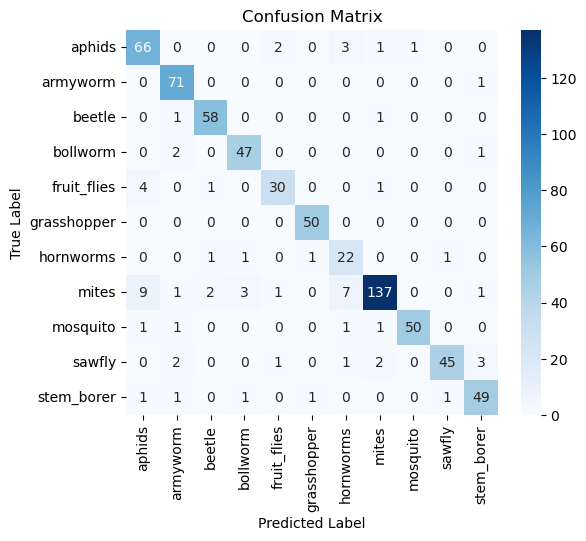

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generate predictions on the testing set
predictions = model.predict(testing_generator)

# Get true labels from the testing generator
y_true = testing_generator.classes

# Extract class labels for clarity
class_labels = list(testing_generator.class_indices.keys())

# Get predicted labels for the test set
y_pred = np.argmax(predictions, axis=1)

# Construct the confusion matrix using sklearn's function
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy (already printed in previous code)
acc=accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1 score (macro and weighted)
precision = precision_score(y_true, y_pred, average=None)  # Calculate per-class precision
recall = recall_score(y_true, y_pred, average=None)  # Calculate per-class recall
f1 = f1_score(y_true, y_pred, average=None)  # Calculate per-class F1 score

# Print per-class precision, recall, and F1 score
print("\nPer-Class Precision:")
print(precision)

print("\nPer-Class Recall:")
print(recall)

print("\nPer-Class F1 Score:")
print(f1)

# Calculate macro-averaged precision, recall, and F1 score
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

# Print macro-averaged metrics
print("\nMacro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 Score:", macro_f1)

# Calculate weighted-averaged precision, recall, and F1 score
weighted_precision = precision_score(y_true, y_pred, average='weighted')
weighted_recall = recall_score(y_true, y_pred, average='weighted')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')


# Print weighted-averaged metrics
print("\nWeighted-averaged Precision:", weighted_precision)
print("Weighted-averaged Recall:", weighted_recall)
print("Weighted-averaged F1 Score:", weighted_f1)

print("Accuracy:",acc)


Per-Class Precision:
[0.81481481 0.89873418 0.93548387 0.90384615 0.88235294 0.96153846
 0.64705882 0.95804196 0.98039216 0.95744681 0.89090909]

Per-Class Recall:
[0.90410959 0.98611111 0.96666667 0.94       0.83333333 1.
 0.84615385 0.85093168 0.92592593 0.83333333 0.90740741]

Per-Class F1 Score:
[0.85714286 0.94039735 0.95081967 0.92156863 0.85714286 0.98039216
 0.73333333 0.90131579 0.95238095 0.89108911 0.89908257]

Macro-averaged Precision: 0.8936926597647887
Macro-averaged Recall: 0.908542989999214
Macro-averaged F1 Score: 0.8986059340572878

Weighted-averaged Precision: 0.9118463635455027
Weighted-averaged Recall: 0.9057971014492754
Weighted-averaged F1 Score: 0.9066097841172975
Accuracy: 0.9057971014492754


In [12]:

model.save('pestdetectmodelbest.h5')

C:\Users\Rounak Rajbhandari\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
#PREDICTION:
import cv2
import numpy as np
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.models import load_model

# Load the trained model
model = load_model('pestdetectmodelbest.h5') 

# Define class labels
class_labels = ['aphids', 'armyworm', 'bettel', 'boolworm','fruit_flies', 'grasshopper','hornworms', 'mites', 'mosquito', 'sawfly', 'stem_borer']

# Function to check if predicted label exists in class labels
def check_label_exists(prediction, class_labels):
    if int(np.argmax(prediction)) not in range(len(class_labels)):
        return f"Error: Predicted label '{class_labels[int(np.argmax(prediction))]}'' does not exist."
    else:
        return None

# Load and preprocess the new image
img_path = 'Image_9.jpg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make the prediction
predictions = model.predict(img_array)

# Set confidence threshold for insect classification
confidence_threshold = 0.2

# Check if any insect class prediction exceeds confidence threshold
if np.max(predictions) < confidence_threshold:
    print("No insect class predicted.")
else:
    error_message = check_label_exists(predictions, class_labels)
    if error_message:
        print(error_message)
    else:
        predicted_class = class_labels[np.argmax(predictions)]
        print(f"The predicted class is: {predicted_class}")
        print(f"Confidence:{np.max(predictions)}")


1/1 [==============================] - 1s 913ms/step
The predicted class is: fruit_flies
Confidence:0.42668962478637695
